# Compliance Types and Principal Strata

**Chapter 9, Section 1**

This notebook introduces the four compliance types in randomized experiments with imperfect compliance, forming the foundation for LATE estimation.

## Table of Contents
1. [Intuition](#intuition) - Not everyone complies
2. [Formal Treatment](#formal) - Principal strata definitions
3. [Numeric Demonstration](#numeric) - Push notification compliance
4. [Implementation](#implementation) - Classifying compliance
5. [Interview Appendix](#interview) - Practice questions

---

In [1]:
# Standard imports
import sys
sys.path.insert(0, '../..')

from facure_augment.common import *

# Set notebook style
set_notebook_style()

print("Imports complete")

Imports complete


---

## Intuition

### The Compliance Problem

In an ideal randomized experiment, everyone assigned to treatment takes it, and everyone assigned to control doesn't. **Reality is messier**.

Consider a push notification experiment:
- Some users assigned to receive a push have older phones that can't display it (never-takers)
- If the push could somehow be accessed without assignment, some would find it (always-takers)

This **non-compliance** creates four distinct types of units:

| Type | If Assigned Treatment | If Assigned Control | Behavior |
|------|----------------------|---------------------|----------|
| **Compliers** | Takes treatment | No treatment | Follows assignment |
| **Always-Takers** | Takes treatment | Takes treatment | Always takes, regardless |
| **Never-Takers** | No treatment | No treatment | Never takes, regardless |
| **Defiers** | No treatment | Takes treatment | Does opposite |

**Insight**: Each unit belongs to exactly ONE stratum, but we can never observe which one directly!

---

### The Fundamental Problem

We observe:
- $Z_i$: Treatment **assignment** (random)
- $D_i$: Treatment **received** (potentially confounded)
- $Y_i$: Outcome

We want the effect of $D$ on $Y$, but:
1. Using $D$ directly is biased (confounders affect who complies)
2. Using $Z$ gives the wrong quantity (effect of assignment, not treatment)

```
    Z (random)  ────────────────────>
         ↓                           ↘
         D ─────────────────────────> Y
         ↑                           ↗
    U (unobserved) ─────────────────>
```

**Solution**: IV/LATE framework leverages compliance structure.

In [2]:
# Load push notification data
push = load_facure_data("app_engagement_push.csv")

print(f"Data: {len(push):,} users")
print(f"\nVariables:")
print(f"  push_assigned (Z): Treatment assignment (random)")
print(f"  push_delivered (D): Treatment received (affected by phone type)")
print(f"  in_app_purchase (Y): Outcome (Brazilian reais)")

push.head()

Data: 10,000 users

Variables:
  push_assigned (Z): Treatment assignment (random)
  push_delivered (D): Treatment received (affected by phone type)
  in_app_purchase (Y): Outcome (Brazilian reais)


,in_app_purchase,push_assigned,push_delivered
0,47,1,1
1,43,1,0
2,51,1,1
3,49,0,0
4,79,0,0


---

## Formal Treatment

### Principal Strata with Potential Outcomes

Define **potential treatment** under each assignment:
- $D_i(1)$: Treatment unit $i$ would receive if assigned ($Z_i = 1$)
- $D_i(0)$: Treatment unit $i$ would receive if not assigned ($Z_i = 0$)

The **principal strata** are defined by the pair $(D_i(0), D_i(1))$:

| Stratum | $D_i(0)$ | $D_i(1)$ | Description |
|---------|----------|----------|-------------|
| Compliers | 0 | 1 | Treatment only when assigned |
| Always-Takers | 1 | 1 | Treatment regardless of assignment |
| Never-Takers | 0 | 0 | No treatment regardless of assignment |
| Defiers | 1 | 0 | Treatment only when NOT assigned |

### Key Property

Strata membership is a **pre-treatment characteristic**. It's determined before randomization, so:

$$\text{Stratum}_i \perp Z_i$$

This means the proportion of each stratum is the same in treatment and control groups.

### Double-Index Potential Outcomes

We can write potential outcomes with double indexing:

$$Y_i(z, d) = \text{Outcome if assignment is } z \text{ and treatment is } d$$

Under the **exclusion restriction** (assignment affects outcome only through treatment):

$$Y_i(1, d) = Y_i(0, d) = Y_i(d) \quad \forall d$$

This simplifies to the standard potential outcomes:
- $Y_i(1)$: Outcome if treated
- $Y_i(0)$: Outcome if not treated

The **individual treatment effect** is:
$$\tau_i = Y_i(1) - Y_i(0)$$

### Observed Outcomes by Stratum

What do we observe for each stratum?

| Stratum | If $Z=1$ | If $Z=0$ |
|---------|----------|----------|
| Compliers | $Y_i(1)$ | $Y_i(0)$ |
| Always-Takers | $Y_i(1)$ | $Y_i(1)$ |
| Never-Takers | $Y_i(0)$ | $Y_i(0)$ |
| Defiers | $Y_i(0)$ | $Y_i(1)$ |

**Insight**: Only for **compliers** does assignment change the treatment, so only for compliers can we learn about treatment effects from variation in $Z$.

---

In [3]:
# Analyze compliance in the push data
print("COMPLIANCE ANALYSIS")
print("=" * 55)

# Cross-tabulation: Assignment vs Delivery
crosstab = pd.crosstab(
    push['push_assigned'], 
    push['push_delivered'],
    margins=True,
    margins_name='Total'
)
crosstab.index = ['Not Assigned (Z=0)', 'Assigned (Z=1)', 'Total']
crosstab.columns = ['Not Delivered (D=0)', 'Delivered (D=1)', 'Total']

print("\nCross-tabulation (Counts):")
print(crosstab)

COMPLIANCE ANALYSIS

Cross-tabulation (Counts):
                    Not Delivered (D=0)  Delivered (D=1)  Total
Not Assigned (Z=0)                 5057                0   5057
Assigned (Z=1)                     1396             3547   4943
Total                              6453             3547  10000


In [4]:
# Compliance rates
assigned = push[push['push_assigned'] == 1]
not_assigned = push[push['push_assigned'] == 0]

# First stage: P(D=1 | Z=1) - P(D=1 | Z=0)
p_d1_z1 = assigned['push_delivered'].mean()
p_d1_z0 = not_assigned['push_delivered'].mean()

print(f"\nCompliance Rates:")
print(f"  P(D=1 | Z=1) = {p_d1_z1:.1%}  (Assigned who received)")
print(f"  P(D=1 | Z=0) = {p_d1_z0:.1%}  (Not assigned who received)")
print(f"\nFirst Stage: {p_d1_z1 - p_d1_z0:.1%}")


Compliance Rates:
  P(D=1 | Z=1) = 71.8%  (Assigned who received)
  P(D=1 | Z=0) = 0.0%  (Not assigned who received)

First Stage: 71.8%


---

## Numeric Demonstration

### Identifying Strata Proportions

Even though we can't observe individual strata, we can estimate their **population proportions** from the data.

In [5]:
# Estimate stratum proportions
# Under monotonicity (no defiers), we can identify:

# P(D=1 | Z=0) = P(Always-Taker)  [they take even when not assigned]
pi_at = p_d1_z0

# P(D=0 | Z=1) = P(Never-Taker)  [they don't take even when assigned]
pi_nt = 1 - p_d1_z1

# P(Complier) = 1 - P(AT) - P(NT)  [under no defiers]
pi_c = 1 - pi_at - pi_nt

# Equivalently: P(Complier) = P(D=1|Z=1) - P(D=1|Z=0) = First Stage
pi_c_alt = p_d1_z1 - p_d1_z0

print("ESTIMATED STRATUM PROPORTIONS")
print("=" * 55)
print(f"\n  Compliers:      {pi_c:.1%}")
print(f"  Always-Takers:  {pi_at:.1%}")
print(f"  Never-Takers:   {pi_nt:.1%}")
print(f"  Defiers:        0.0% (assumed under monotonicity)")
print(f"\nVerification: {pi_c + pi_at + pi_nt:.1%} (should be 100%)")
print(f"\nNote: P(Complier) = First Stage = {pi_c_alt:.1%}")

ESTIMATED STRATUM PROPORTIONS

  Compliers:      71.8%
  Always-Takers:  0.0%
  Never-Takers:   28.2%
  Defiers:        0.0% (assumed under monotonicity)

Verification: 100.0% (should be 100%)

Note: P(Complier) = First Stage = 71.8%


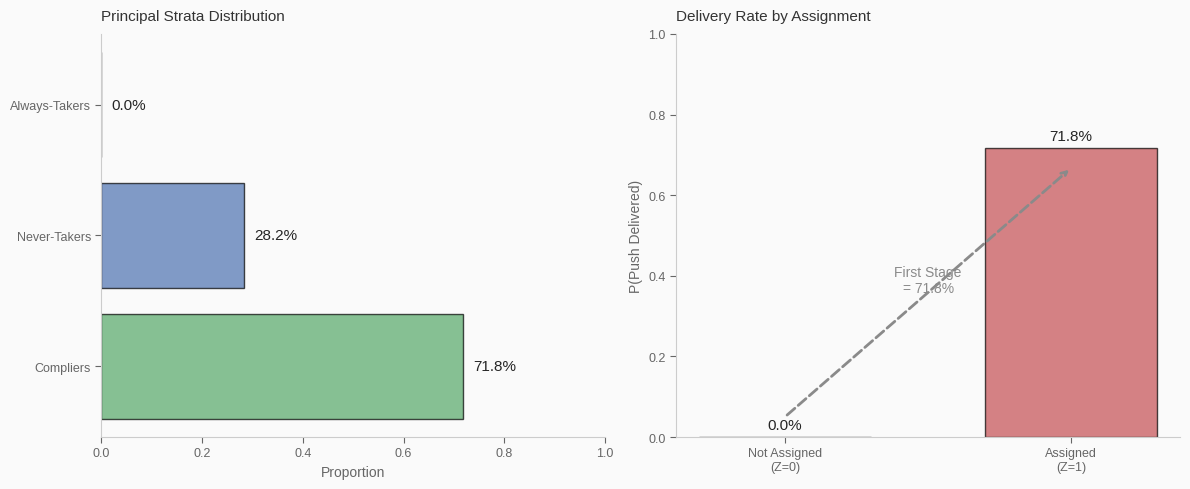

In [6]:
# Visualize the compliance structure
fig, axes = create_tufte_figure(ncols=2, figsize=(12, 5))

# Left: Stratum proportions (pie chart alternative - bar)
ax = axes[0]
strata = ['Compliers', 'Never-Takers', 'Always-Takers']
proportions = [pi_c, pi_nt, pi_at]
colors_strata = [COLORS['green'], COLORS['blue'], COLORS['red']]

bars = ax.barh(strata, proportions, color=colors_strata, edgecolor='black', alpha=0.7)
for bar, prop in zip(bars, proportions):
    ax.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2, 
            f'{prop:.1%}', va='center', fontsize=11)

ax.set_xlim(0, 1)
set_tufte_title(ax, "Principal Strata Distribution")
set_tufte_labels(ax, "Proportion", "")

# Right: Delivery rates by assignment
ax = axes[1]
x_pos = [0, 1]
delivery_rates = [p_d1_z0, p_d1_z1]
labels = ['Not Assigned\n(Z=0)', 'Assigned\n(Z=1)']

bars = ax.bar(x_pos, delivery_rates, color=[COLORS['blue'], COLORS['red']], 
              edgecolor='black', alpha=0.7, width=0.6)

# Add values
for bar, rate in zip(bars, delivery_rates):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
            f'{rate:.1%}', ha='center', fontsize=11)

# Show first stage as arrow
ax.annotate('', xy=(1, p_d1_z1 - 0.05), xytext=(0, p_d1_z0 + 0.05),
            arrowprops=dict(arrowstyle='->', color=COLORS['gray'], lw=2, ls='--'))
ax.text(0.5, (p_d1_z1 + p_d1_z0)/2, f'First Stage\n= {pi_c:.1%}', 
        ha='center', fontsize=10, color=COLORS['gray'])

ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_ylim(0, 1)
set_tufte_title(ax, "Delivery Rate by Assignment")
set_tufte_labels(ax, "", "P(Push Delivered)")

plt.tight_layout()
plt.show()

### Interpreting the Push Notification Example

**What we found**:
- ~72% are **compliers**: They get the push when assigned, don't get it otherwise
- ~28% are **never-takers**: Older phones can't receive the fancy push notification
- ~0% are **always-takers**: No way to get the push without being assigned

**Why this matters**:
- The treatment effect we can estimate (LATE) applies only to the 72% compliers
- Never-takers may have different treatment effects (if they could receive the push)
- External validity concern: Compliers are likely richer (newer phones)

In [7]:
# Show the selection problem
print("THE SELECTION PROBLEM")
print("=" * 55)

# Among assigned: compare delivered vs not delivered
assigned_delivered = push[(push['push_assigned'] == 1) & (push['push_delivered'] == 1)]
assigned_not_delivered = push[(push['push_assigned'] == 1) & (push['push_delivered'] == 0)]

print(f"\nAmong those ASSIGNED (Z=1):")
print(f"  Delivered (D=1): n={len(assigned_delivered)}, mean purchase = ${assigned_delivered['in_app_purchase'].mean():.2f}")
print(f"  Not Delivered (D=0): n={len(assigned_not_delivered)}, mean purchase = ${assigned_not_delivered['in_app_purchase'].mean():.2f}")

naive_effect = assigned_delivered['in_app_purchase'].mean() - assigned_not_delivered['in_app_purchase'].mean()
print(f"\nNaive comparison: ${naive_effect:.2f}")
print(f"\nBUT: This is BIASED!")
print(f"  - Those who received have newer phones (richer)")
print(f"  - Richer people make more purchases regardless of push")
print(f"  - Selection bias overstates the apparent effect")

THE SELECTION PROBLEM

Among those ASSIGNED (Z=1):
  Delivered (D=1): n=3547, mean purchase = $79.45
  Not Delivered (D=0): n=1396, mean purchase = $51.85

Naive comparison: $27.60

BUT: This is BIASED!
  - Those who received have newer phones (richer)
  - Richer people make more purchases regardless of push
  - Selection bias overstates the apparent effect


---

## Implementation

### Compliance Classification Function

In [8]:
def analyze_compliance(df, assignment_col, treatment_col):
    """
    Analyze compliance structure in an RCT with non-compliance.
    
    Parameters
    ----------
    df : pd.DataFrame
        Data with assignment and treatment columns.
    assignment_col : str
        Column name for treatment assignment (Z).
    treatment_col : str
        Column name for treatment received (D).
        
    Returns
    -------
    dict
        Compliance statistics.
    """
    Z = df[assignment_col]
    D = df[treatment_col]
    
    # Compliance rates
    p_d1_z1 = D[Z == 1].mean()  # P(D=1 | Z=1)
    p_d1_z0 = D[Z == 0].mean()  # P(D=1 | Z=0)
    p_d0_z1 = 1 - p_d1_z1       # P(D=0 | Z=1)
    p_d0_z0 = 1 - p_d1_z0       # P(D=0 | Z=0)
    
    # First stage
    first_stage = p_d1_z1 - p_d1_z0
    
    # Stratum proportions (under monotonicity)
    pi_always_takers = p_d1_z0
    pi_never_takers = p_d0_z1
    pi_compliers = first_stage
    
    # Check for defiers (would require p_d1_z0 > p_d1_z1)
    potential_defiers = first_stage < 0
    
    return {
        'n': len(df),
        'p_d1_z1': p_d1_z1,
        'p_d1_z0': p_d1_z0,
        'first_stage': first_stage,
        'pi_compliers': pi_compliers,
        'pi_always_takers': pi_always_takers,
        'pi_never_takers': pi_never_takers,
        'potential_defiers': potential_defiers,
        'monotonicity_plausible': not potential_defiers
    }

# Test on push data
compliance = analyze_compliance(push, 'push_assigned', 'push_delivered')

print("Compliance Analysis Results:")
for key, value in compliance.items():
    if isinstance(value, float):
        print(f"  {key}: {value:.4f}")
    else:
        print(f"  {key}: {value}")

Compliance Analysis Results:
  n: 10000
  p_d1_z1: 0.7176
  p_d1_z0: 0.0000
  first_stage: 0.7176
  pi_compliers: 0.7176
  pi_always_takers: 0.0000
  pi_never_takers: 0.2824
  potential_defiers: False
  monotonicity_plausible: True


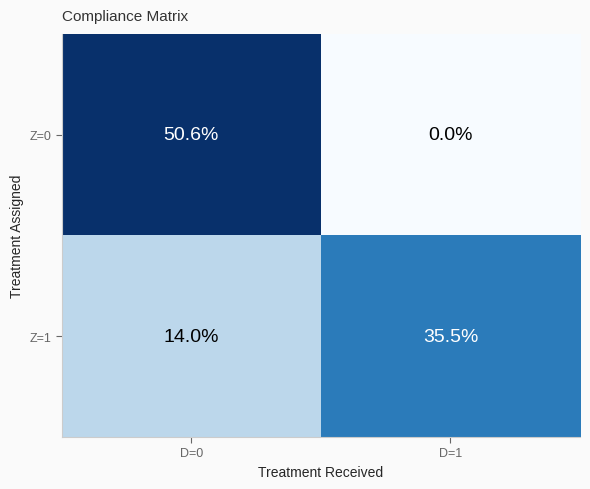

In [9]:
# Crosstab visualization function
def plot_compliance_crosstab(df, assignment_col, treatment_col, ax=None):
    """
    Create a visual representation of the compliance crosstab.
    """
    if ax is None:
        fig, ax = create_tufte_figure(figsize=(8, 6))
    
    # Compute proportions
    Z = df[assignment_col]
    D = df[treatment_col]
    
    # Four cells
    cells = [
        ((Z == 0) & (D == 0)).mean(),  # Z=0, D=0
        ((Z == 0) & (D == 1)).mean(),  # Z=0, D=1
        ((Z == 1) & (D == 0)).mean(),  # Z=1, D=0
        ((Z == 1) & (D == 1)).mean(),  # Z=1, D=1
    ]
    
    # Create heatmap-like display
    matrix = np.array([[cells[0], cells[1]], [cells[2], cells[3]]])
    
    im = ax.imshow(matrix, cmap='Blues', aspect='auto', vmin=0, vmax=0.5)
    
    # Add text annotations
    for i in range(2):
        for j in range(2):
            text = f'{matrix[i, j]:.1%}'
            ax.text(j, i, text, ha='center', va='center', fontsize=14,
                   color='white' if matrix[i, j] > 0.25 else 'black')
    
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['D=0', 'D=1'])
    ax.set_yticklabels(['Z=0', 'Z=1'])
    ax.set_xlabel('Treatment Received')
    ax.set_ylabel('Treatment Assigned')
    
    return ax

fig, ax = create_tufte_figure(figsize=(6, 5))
plot_compliance_crosstab(push, 'push_assigned', 'push_delivered', ax)
set_tufte_title(ax, "Compliance Matrix")
plt.tight_layout()
plt.show()

---

## Interview Appendix

### Practice Questions

**Q1: What are the four compliance types in an RCT with non-compliance?**

<details>
<summary>Solution</summary>

The four principal strata defined by potential treatment $(D(0), D(1))$:

| Type | $D(0)$ | $D(1)$ | Behavior |
|------|--------|--------|----------|
| **Compliers** | 0 | 1 | Follow assignment |
| **Always-Takers** | 1 | 1 | Always take treatment |
| **Never-Takers** | 0 | 0 | Never take treatment |
| **Defiers** | 1 | 0 | Do opposite of assignment |

**Key insight**: Stratum membership is a pre-treatment characteristic we cannot directly observe. We identify it only through the combination of assignment and treatment status.

</details>

**Q2: Why can't we simply compare treated vs. untreated to estimate the treatment effect?**

<details>
<summary>Solution</summary>

**Selection bias**: Treatment receipt $D$ is typically correlated with potential outcomes.

In the push notification example:
- Those who receive the push have newer phones (they're compliers)
- Newer phones → higher income → higher baseline purchases
- So $E[Y_0 | D=1] > E[Y_0 | D=0]$ (positive selection)

The naive comparison:
$$E[Y | D=1] - E[Y | D=0] = \underbrace{\text{ATE}}_{\text{causal}} + \underbrace{E[Y_0|D=1] - E[Y_0|D=0]}_{\text{selection bias}}$$

Assignment $Z$ is random, but treatment $D$ is not!

</details>

**Q3: How do you estimate the proportion of compliers from data?**

<details>
<summary>Solution</summary>

Under **monotonicity** (no defiers):

$$\pi_C = P(\text{Complier}) = P(D=1|Z=1) - P(D=1|Z=0)$$

This is the **first stage** coefficient.

**Derivation**:
- $P(D=1|Z=1) = P(\text{Complier}) + P(\text{Always-Taker})$
- $P(D=1|Z=0) = P(\text{Always-Taker})$ (only they take when not assigned)
- Subtracting: $P(D=1|Z=1) - P(D=1|Z=0) = P(\text{Complier})$

We can also identify:
- $\pi_{AT} = P(D=1|Z=0)$
- $\pi_{NT} = P(D=0|Z=1)$

</details>

---

## References

[^1]: Facure, M. (2022). *Causal Inference for the Brave and True*, Chapter 9.

[^2]: Angrist, J. D., Imbens, G. W., & Rubin, D. B. (1996). Identification of causal effects using instrumental variables. *JASA*, 91(434), 444-455.

[^3]: Cross-reference: IV theory in `08_instrumental_variables/01_iv_intuition.ipynb`